# StreetViewGAN - Translating Between Maps and Real World Images

In [263]:
import os, random, pathlib, tarfile, urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode, functional as TF
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr

# # For reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

%matplotlib inline

## Download the Dataset

In [264]:
# dataset_name = "maps"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# # Download and extract the dataset
# def download_and_extract(url, download_path):
#     if not download_path.exists():
#         print(f"Downloading {url}...")
#         tar_path, _ = urllib.request.urlretrieve(url)
#         print(f"Extracting to {download_path}...")
#         with tarfile.open(tar_path, "r:gz") as tar:
#             tar.extractall(path=download_path.parent)
#     else:
#         print(f"{dataset_name} already downloaded.")

# # Set paths
# base_path = pathlib.Path('./data')
# download_path = base_path / dataset_name
# base_path.mkdir(exist_ok=True)

# download_and_extract(_URL, download_path)

# # Now dataset is available at:
# print("Dataset path:", download_path)

## Data Preprocessing

In [265]:
full_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomCrop((256, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
])

to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [266]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, mode='train', full_transform=None, to_tensor=None):
        self.files = sorted((pathlib.Path(root_dir)/mode).glob("*.jpg"))
        self.full_transform = full_transform
        self.to_tensor       = to_tensor

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = PILImage.open(self.files[idx]).convert("RGB")   
        if self.full_transform:
            img = self.full_transform(img)                  

        w, h = img.size 
        w2   = w // 2

        street_pil = img.crop((0,    0, w2, h))  # left half
        map_pil    = img.crop((w2,   0,  w, h))  # right half

        if self.to_tensor:
            street = self.to_tensor(street_pil)  # Tensor [3×256×256]
            map_   = self.to_tensor(map_pil)     # Tensor [3×256×256]
        else:
            street, map_ = street_pil, map_pil

        return street, map_

In [267]:
bs = 1
data_dir = "./data/maps"

train_ds = Pix2PixDataset(data_dir, mode='train',
                          full_transform=full_transform,
                          to_tensor=to_tensor_norm)
val_ds   = Pix2PixDataset(data_dir, mode='val',
                          full_transform=full_transform,
                          to_tensor=to_tensor_norm)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=24, shuffle=False, num_workers=0)


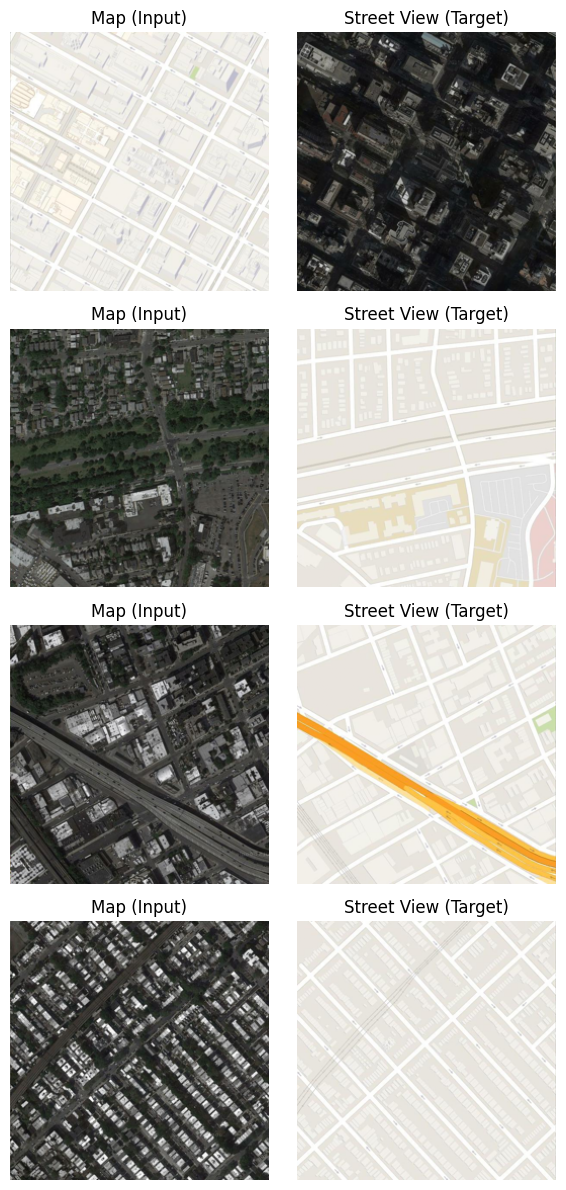

In [268]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12))
for i, (street, map_) in enumerate(train_dl):
    if i == 4: break

    inp = map_ * 0.5 + 0.5
    tgt = street * 0.5 + 0.5

    axes[i,0].imshow(inp[0].permute(1,2,0))
    axes[i,0].set_title("Map (Input)")
    axes[i,1].imshow(tgt[0].permute(1,2,0))
    axes[i,1].set_title("Street View (Target)")
    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

## Discriminator Network

In [269]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        # Since we concatwnate two images, the first conv sees in_channels*2
        self.model = nn.Sequential(
        # → (in_channels*2) x 256 x 256
        nn.Conv2d(in_channels * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features),
        nn.LeakyReLU(0.2, inplace=True),
        # → base_features x 128 x 128

        nn.Conv2d(base_features, base_features*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*2),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*2) x 64 x 64

        nn.Conv2d(base_features*2, base_features*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*4),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*4) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*4) x 34 x 34

        nn.Conv2d(base_features*4, base_features*8, kernel_size=4, stride=1, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*8),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*8) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*8) x 34 x 34

        # final “patch” conv; produces a 31×31 score map
        nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1, bias=False),
        # → 1 x 31 x 31
        nn.Sigmoid(),
        )

    def forward(self, real_input, real_target):
        x = torch.cat([real_input, real_target], dim = 1)  
        return self.model(x)

## Generator Network

In [270]:
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # --- ENCODER (downsampling) ---
        # 256→128
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 128→64
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 64→32
        self.enc3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 32→16
        self.enc4 = nn.Sequential(
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 16→8
        self.enc5 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 8→4
        self.enc6 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 4→2
        self.enc7 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 2→1  (bottleneck)
        self.enc8 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # --- DECODER (upsampling) ---
        # 1→2
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 2→4 (cat → 16 channels in)
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 4→8
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 8→16
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.ReLU(inplace=True)
        )
        # 16→32 (cat 16+16→32 channels)
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*4),
            nn.ReLU(inplace=True)
        )
        # 32→64
        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(features*4*2, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*2),
            nn.ReLU(inplace=True)
        )
        # 64→128
        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(features*2*2, features,   kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # final 128→256 & 3 channels
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)   # 256→128
        e2 = self.enc2(e1)  # 128→64
        e3 = self.enc3(e2)  # 64→32
        e4 = self.enc4(e3)  # 32→16
        e5 = self.enc5(e4)  # 16→8
        e6 = self.enc6(e5)  # 8→4
        e7 = self.enc7(e6)  # 4→2
        e8 = self.enc8(e7)  # 2→1  (bottleneck)

        # --- decode & concat skips ---
        d1 = self.dec1(e8); d1 = torch.cat([d1, e7], dim=1)  # 1→2
        d2 = self.dec2(d1); d2 = torch.cat([d2, e6], dim=1)  # 2→4
        d3 = self.dec3(d2); d3 = torch.cat([d3, e5], dim=1)  # 4→8
        d4 = self.dec4(d3); d4 = torch.cat([d4, e4], dim=1)  # 8→16
        d5 = self.dec5(d4); d5 = torch.cat([d5, e3], dim=1)  # 16→32
        d6 = self.dec6(d5); d6 = torch.cat([d6, e2], dim=1)  # 32→64
        d7 = self.dec7(d6); d7 = torch.cat([d7, e1], dim=1)  # 64→128

        return self.final(d7) # → 256×256×3

## Discriminator Training

In [271]:
def train_discriminator(discriminator, generator, real_images, map_images, opt_d):
    discriminator.train()
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds = discriminator(real_images, map_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = 0.5 * F.binary_cross_entropy_with_logits(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_images = generator(real_images).detach()
    fake_preds = discriminator(real_images, fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss    = 0.5 * F.binary_cross_entropy_with_logits(fake_preds, fake_targets)
    fake_score   = fake_preds.mean().item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## Generator Training

In [272]:
def train_generator(discriminator, generator, real_images, map_images, opt_g, lambda_L1 = 100):
    generator.train()

    total_loss = 0.0
    adv_loss = 0.0
    l1_loss = 0.0

    # Train G twice per D step
    for _ in range(2):  
        # Clear generator gradients                                     
        opt_g.zero_grad()

        # 1) Adversarial loss
        # Generate fake images
        fake_images = generator(real_images)

        # Try to fool the discriminator
        preds = discriminator(real_images, fake_images)
        targets = torch.ones_like(preds)
        adv_loss = F.binary_cross_entropy_with_logits(preds, targets)

        # 2) L1 reconstruction loss
        l1_loss  = F.l1_loss(fake_images, map_images)

        total_loss = adv_loss + (lambda_L1 * l1_loss)

        total_loss.backward()
        opt_g.step()

        total_loss += total_loss.item()
        adv_loss   += adv_loss.item()
        l1_loss    += l1_loss.item()

    # Average over the two updates
    return total_loss / 2, adv_loss / 2, l1_loss / 2

In [273]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

In [274]:
def save_samples(idx, street_batch, generator, denorm, show=True):
    generator.eval()
    with torch.no_grad():
        fake = generator(street_batch)         

    # Denormalize into [0,1] for saving/viewing
    fake = denorm(fake)

    fname = f'generated-images-{idx:04d}.png'
    save_image(fake, os.path.join(sample_dir, fname), nrow=8)
    print('Saving', fname)

    if show:
        grid = make_grid(fake.cpu(), nrow=8)   # shape (3, H, W)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0)) # H×W×3
        plt.show()

## Full Training Loop

In [275]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [276]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias, 0)

In [277]:
def fit(
    discriminator: nn.Module,
    generator:     nn.Module,
    train_dl,
    fixed_streets,        # a batch of streets images, e.g. next(iter(val_dl))
    denorm,               # function mapping [-1,1]→[0,1]
    device = None,
    epochs = 200,
    lr = 2e-4,
    start_idx = 1
):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
   
    # ── LR schedulers: decay LR by 0.5 every 25 epochs ──
    sched_d = torch.optim.lr_scheduler.StepLR(opt_d, step_size=25, gamma=0.5)
    sched_g = torch.optim.lr_scheduler.StepLR(opt_g, step_size=25, gamma=0.5)

    for epoch in range(start_idx, start_idx + epochs):
        sum_d = sum_g = 0.0
        sum_real_s = sum_fake_s = 0.0
        n = 0

        for street_imgs, map_imgs in tqdm(train_dl, desc=f"Epoch {epoch}/{start_idx+epochs-1}"):
            # — Train D —
            d_loss, real_s, fake_s = train_discriminator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_d
            )

            # — Train G —
            g_loss, adv_loss, l1_loss = train_generator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_g
            )

            sum_d       += d_loss
            sum_g       += g_loss
            sum_real_s  += real_s
            sum_fake_s  += fake_s
            n           += 1

        # Averages
        avg_d = sum_d / n
        avg_g = sum_g / n
        avg_real = sum_real_s / n
        avg_fake = sum_fake_s / n

        # Record losses & scores
        losses_d.append(avg_d)
        losses_g.append(avg_g)
        real_scores.append(avg_real)
        fake_scores.append(avg_fake)

        # Log losses & scores (last batch)
        print(
            f"Epoch [{epoch}]  "
            f"loss_g: {avg_g:.4f}, loss_d: {avg_d:.4f}, "
            f"real_score: {avg_real:.4f}, fake_score: {avg_fake:.4f}"
        )

        # Save generated images
        save_samples(epoch, fixed_streets, generator, denorm)

        # Step the schedulers each epoch
        sched_d.step()
        sched_g.step()

        if epoch % 5 == 0:
            torch.save(generator.state_dict(), f"checkpoint_gen_epoch{epoch}.pth")

    return losses_g, losses_d, real_scores, fake_scores

In [278]:
discriminator = Pix2PixDiscriminator()
generator     = Pix2PixGenerator()

generator.apply(init_weights)
discriminator.apply(init_weights)

fixed_streets, _ = next(iter(train_dl))
lr = 0.0002
epochs = 200

history = fit(
    discriminator=discriminator,
    generator=generator,
    train_dl=train_dl,
    fixed_streets=fixed_streets,
    denorm=denorm,
    device=device,  
    epochs=epochs,
    lr=lr,
    start_idx=1
)

losses_g, losses_d, real_scores, fake_scores = history

Epoch 1/200:   0%|          | 2/1096 [00:09<1:22:03,  4.50s/it]

## Checkpointing


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th, and 50th epochs of training.

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0050.png')

## Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_d) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Real & Fake Scores

In [ ]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Generating New Images

In [ ]:
# Building a validation loader
val_ds  = Pix2PixDataset('./data/maps', mode='val')
val_dl  = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
generator = Pix2PixGenerator()
generator.load_state_dict(torch.load('G.pth'))
generator.eval()

# Sampling from val_dl
street_batch, _ = next(iter(val_dl))
fake_batch = generator(street_batch)
fake_batch = denorm(fake_batch)

In [ ]:
# Display Images
grid = make_grid(fake_batch, nrow=5).permute(1,2,0).squeeze()
plt.figure(figsize=(25,3), dpi=100)
plt.axis('off')
plt.imshow(grid, interpolation='nearest')
plt.show()

## User Interface

In [ ]:
# Wrapper to run your model end-to-end
def translate(real_img: PIL.Image.Image) -> PIL.Image.Image:
    img = full_augment(real_img)
    street = to_tensor_norm(img.crop((0,0,256,256)))
    x = street.unsqueeze(0).to(device)
    with torch.no_grad():
        fake = generator(x)   # 1×3×256×256
    fake = denorm(fake[0]).clamp(0,1)   # back to [0,1]
    return ToPILImage()(fake)  # PIL for display

In [ ]:
iface = gr.Interface(
    fn=translate,
    inputs=gr.Image(type="pil", label="Input Image"),
    outputs=gr.Image(type="pil", label="Generated Map"),
    title="StreetViewGAN",
    description="Upload a street view image; get the generated map."
)

In [ ]:
# Launch
iface.launch()